In [ ]:
# 기본모델
# memory

In [1]:
conda install tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
data = pd.read_csv('../data/cpu_memory_usage_20230409.csv', header=0)
# 231635
# 781952

In [4]:
data['time'] = pd.to_datetime(data['time'], unit='ns')
data = data.loc[data.namespace == 'drive']
date_time = pd.to_datetime(data['time'], format='%Y-%M-%D %H:%M:%S')
data

,name,tags,time,pod_name,namespace,mean_cpu_usage_nanocores,mean_memory_working_set_bytes
96,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-mpw5q,drive,1.773410e+07,1.334707e+09
100,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-s2kw8,drive,1.748167e+07,1.310027e+09
103,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-888jq,drive,1.104169e+07,1.272855e+09
109,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-bn97q,drive,1.801984e+07,1.403893e+09
112,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-rw5qk,drive,1.457886e+07,1.401893e+09
...,...,...,...,...,...,...,...
781535,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-r6wq2,drive,1.082766e+08,1.202945e+09
781651,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-g5dpb,drive,6.636116e+07,1.283052e+09
781664,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-gw9xt,drive,1.145962e+08,1.308961e+09
781815,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-wklkm,drive,1.155693e+08,1.225552e+09


In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [6]:
data = data.loc[:,['mean_memory_working_set_bytes']]

In [7]:
seq_length = 24
X, Y = create_sequences(data, seq_length)
X.shape, Y.shape
X[0] #1.27417204e+09

array([[1.33470669e+09],
       [1.31002727e+09],
       [1.27285472e+09],
       [1.40389339e+09],
       [1.40189259e+09],
       [1.30463358e+09],
       [1.44382369e+09],
       [1.39535762e+09],
       [1.41588972e+09],
       [1.41645871e+09],
       [1.33890314e+09],
       [1.29920075e+09],
       [1.25934739e+09],
       [1.41135913e+09],
       [1.41291325e+09],
       [1.33008821e+09],
       [1.45881798e+09],
       [1.42025639e+09],
       [1.41348826e+09],
       [1.40255522e+09],
       [1.43363301e+09],
       [1.35977192e+09],
       [1.31844335e+09],
       [1.42308837e+09]])

In [8]:
train_size = 8000
offset_size = 500
X_train, y_train = X[:train_size], Y[:train_size]
X_val, y_val = X[train_size:train_size+offset_size], Y[train_size:train_size+offset_size]
X_test, y_test = X[train_size+offset_size:], Y[train_size+offset_size:]

In [9]:

MIN = X_train.min()
MAX = X_train.max()

In [10]:

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)


In [11]:

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [12]:
y_train = pd.DataFrame(y_train, columns = ['mean_memory_working_set_bytes'])
y_val = pd.DataFrame(y_val, columns = ['mean_memory_working_set_bytes'])

y_test = pd.DataFrame(y_test, columns = ['mean_memory_working_set_bytes'])
y_test


,mean_memory_working_set_bytes
0,0.184795
1,0.131135
2,0.319655
3,0.215983
4,0.222026
...,...
1024,0.163620
1025,0.237155
1026,0.260938
1027,0.184372


In [13]:

X_train_tensors_f = tf.reshape(X_train,   (X_train.shape[0], 1, X_train.shape[1]))
X_test_tensors_f = tf.reshape(X_test,  (X_test.shape[0], 1, X_test.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test.shape) 


Training Shape (8000, 1, 24) (8000, 1)
Testing Shape (1029, 1, 24) (1029, 1)


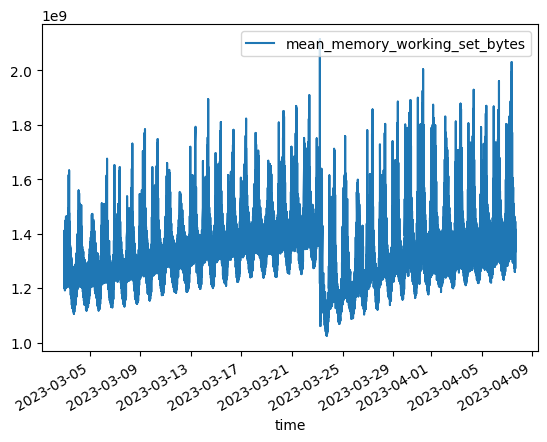

In [14]:
plot_cols = ['mean_memory_working_set_bytes']
plot_features = data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# plot_features = data[plot_cols][:1440]
# plot_features.index = date_time[:1440]
# _ = plot_features.plot(subplots=True)

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=y_train, test_df=y_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example

In [19]:
single_step_window = WindowGenerator(
    input_width=96, label_width=96, shift=1,
    label_columns=['mean_memory_working_set_bytes'])
single_step_window

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Label column name(s): ['mean_memory_working_set_bytes']

In [20]:
example_window = tf.stack([np.array(y_train[:single_step_window.total_window_size]),
                           np.array(y_train[1000:1000+single_step_window.total_window_size]),
                           np.array(y_train[2000:2000+single_step_window.total_window_size])])

example_inputs, example_labels = single_step_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 97, 1)
Inputs shape: (3, 96, 1)
Labels shape: (3, 96, 1)


In [1]:

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 

In [21]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [22]:
column_indices = {name: i for i, name in enumerate(data.columns)}
baseline = Baseline(label_index=column_indices['mean_memory_working_set_bytes'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

performance = {}
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
performance

2023-04-09 16:31:34.294346: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


{'Baseline': [0.007671995088458061, 0.06781327724456787]}

In [23]:
inputs, labels = single_step_window.example
train_predict = baseline(inputs)
train_predict.shape

TensorShape([32, 96, 1])

In [24]:
plot_col_index = single_step_window.column_indices['mean_memory_working_set_bytes']
plot_col_index

0

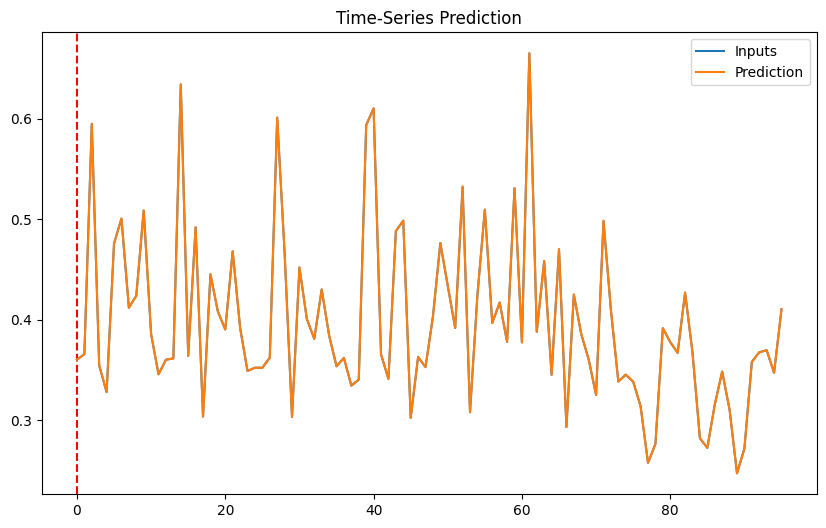

In [25]:

plt.figure(figsize=(10,6)) 
plt.axvline(c='r', linestyle='--') 
plt.plot(single_step_window.input_indices, inputs[0, :, plot_col_index],
            label='Inputs')
plt.plot(single_step_window.input_indices, train_predict[0, :, single_step_window.label_columns_indices.get('mean_memory_working_set_bytes', None)],
            label='Prediction')
# plt.scatter(single_step_window.label_indices, train_predict[0, :, single_step_window.label_columns_indices.get('memory_working_set_bytes', None)],
#             marker='X', edgecolors='k', label='Predictions',
#             c='#ff7f0e', s=64)

plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [56]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False,activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [70]:
y_train.shape, X_train_tensors_f.shape

((8000, 1), TensorShape([8000, 1, 24]))

In [69]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint

MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = lstm_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/1000
221/250 [=========================>....] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0556
Epoch 1: loss improved from inf to 0.00576, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 1s 792us/step - loss: 0.0058 - mean_absolute_error: 0.0558
Epoch 2/1000
247/250 [============================>.] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0556
Epoch 2: loss improved from 0.00576 to 0.00572, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 0s 657us/step - loss: 0.0057 - mean_absolute_error: 0.0556
Epoch 3/1000
164/250 [==================>...........] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0563
Epoch 3: loss did not improve from 0.00572
250/250 [==============================] - 0s 600us/step - loss: 0.0057 - mean_absolute_error: 0.0556
Epoch 4/1000
169/250 [===================>..........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0553
Epoch 4: loss improved from 0.00572 t

In [60]:
y_train

,mean_memory_working_set_bytes
0,0.229003
1,0.373994
2,0.402996
3,0.288880
4,0.372107
...,...
7995,0.258100
7996,0.232177
7997,0.273975
7998,0.375783


In [28]:
performance['lstm_model'] = lstm_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [59]:
X_test_tensors_f.shape

TensorShape([1029, 1, 24])

In [29]:
train_predict = lstm_model.predict(X_test_tensors_f)

33/33 [==============================] - 0s 464us/step


In [58]:
train_predict.shape

(1029, 1, 1)

In [52]:
lstm_model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

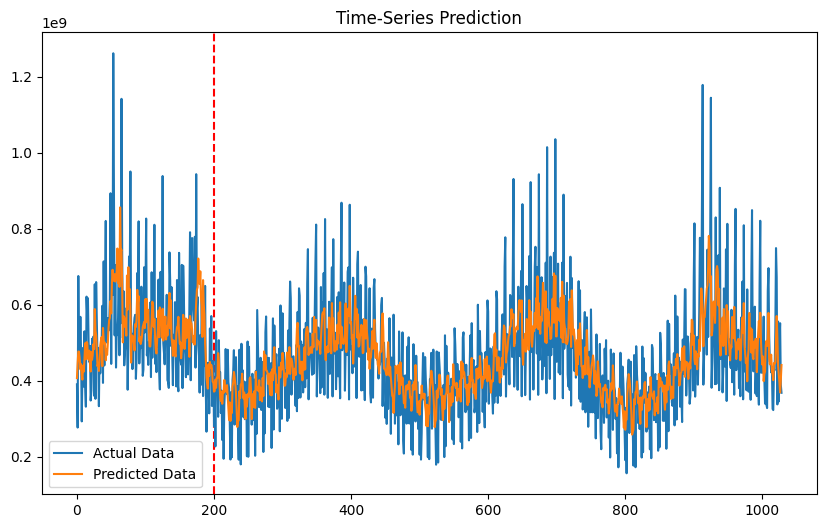

In [30]:

predicted= train_predict * MAX
label_y = y_test * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [31]:
gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [32]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')

gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = gru_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/1000
217/250 [=========================>....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0639
Epoch 1: loss improved from inf to 0.00723, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0629
Epoch 2/1000
167/250 [===================>..........] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0575
Epoch 2: loss improved from 0.00723 to 0.00623, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 0s 626us/step - loss: 0.0062 - mean_absolute_error: 0.0579
Epoch 3/1000
243/250 [============================>.] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0576
Epoch 3: loss improved from 0.00623 to 0.00613, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 0s 665us/step - loss: 0.0061 - mean_absolute_error: 0.0575
Epoch 4/1000
220/250 [=========================>....] - ETA: 0s - loss: 0.0060 - mean_absolute_error

In [33]:
performance['gru_model'] = gru_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [34]:
train_predict = gru_model(X_test_tensors_f)
train_predict.shape

TensorShape([1029, 1])

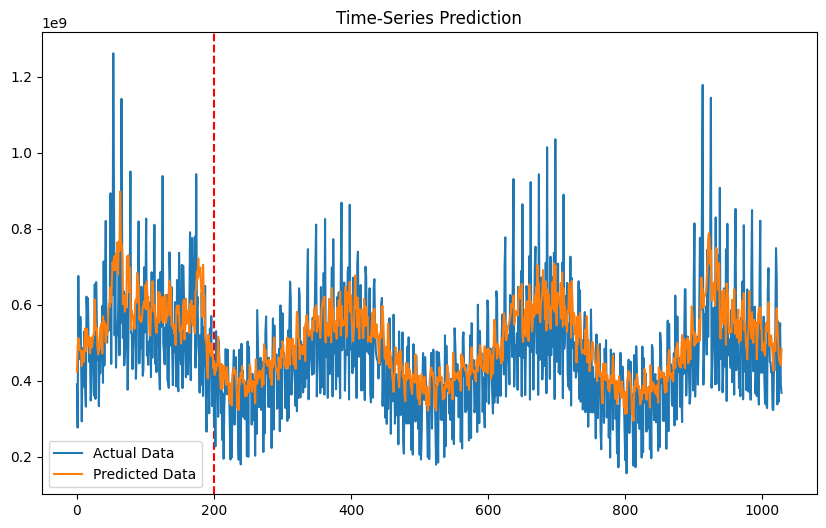

In [35]:
predicted= train_predict * MAX
label_y = y_test * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [36]:
biLSTM1_model = tf.keras.models.Sequential()
biLSTM1_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
biLSTM1_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
biLSTM1_model.add(tf.keras.layers.Dense(5))
# biLSTM1_model.add(tf.keras.layers.Activation('softmax'))

In [37]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=10,
                                                mode='min')

biLSTM1_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = biLSTM1_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/1000
211/250 [========================>.....] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0810
Epoch 1: loss improved from inf to 0.01278, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 2s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0781
Epoch 2/1000
229/250 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0597
Epoch 2: loss improved from 0.01278 to 0.00649, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0593
Epoch 3/1000
227/250 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0583
Epoch 3: loss improved from 0.00649 to 0.00616, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 0s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0578
Epoch 4/1000
234/250 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.

In [38]:
performance['biLSTM1_model'] = biLSTM1_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [39]:
train_predict = biLSTM1_model.predict(X_test_tensors_f)
train_predict.shape

33/33 [==============================] - 1s 722us/step


(1029, 5)

33/33 [==============================] - 0s 674us/step


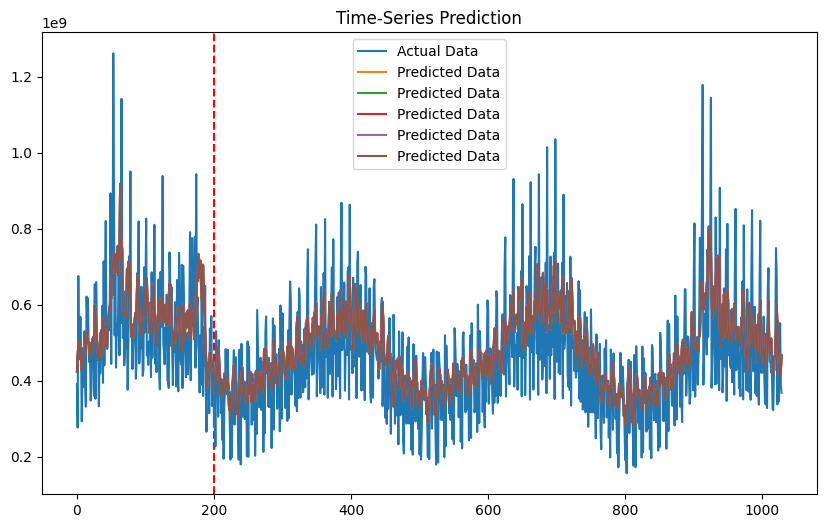

In [40]:

train_predict = biLSTM1_model.predict(X_test_tensors_f)
train_predict.shape
predicted= train_predict * MAX
label_y = y_test * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [41]:
# With custom backward layer
biLSTM2_model = tf.keras.models.Sequential()
forward_layer = tf.keras.layers.LSTM(32, return_sequences=True)
backward_layer = tf.keras.layers.LSTM(32, return_sequences=True,
                      go_backwards=True)
biLSTM2_model.add(tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer))
biLSTM2_model.add(tf.keras.layers.Dense(1))

In [42]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=10,
                                                mode='min')

biLSTM2_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = biLSTM2_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/100
248/250 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0684
Epoch 1: loss improved from inf to 0.00893, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 1s 870us/step - loss: 0.0089 - mean_absolute_error: 0.0683
Epoch 2/100
209/250 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0597
Epoch 2: loss improved from 0.00893 to 0.00644, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 0s 772us/step - loss: 0.0064 - mean_absolute_error: 0.0590
Epoch 3/100
186/250 [=====================>........] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0571
Epoch 3: loss improved from 0.00644 to 0.00606, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 0s 1ms/step - loss: 0.0061 - mean_absolute_error: 0.0573
Epoch 4/100
213/250 [========================>.....] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.

In [43]:
performance['biLSTM2_model'] = biLSTM2_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [44]:
train_predict = biLSTM2_model.predict(X_test_tensors_f)
train_predict.shape
# train_predict

33/33 [==============================] - 0s 644us/step


(1029, 1, 1)

In [45]:
biLSTM3_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=X_train_tensors_f.shape[-2:]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dense(128, activation='selu'),
        tf.keras.layers.Dense(1),
    ])

In [46]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=10,
                                                mode='min')

biLSTM3_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = biLSTM3_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0684
Epoch 1: loss improved from inf to 0.00882, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 15s 48ms/step - loss: 0.0088 - mean_absolute_error: 0.0684
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0596
Epoch 2: loss improved from 0.00882 to 0.00655, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 12s 50ms/step - loss: 0.0066 - mean_absolute_error: 0.0596
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0589
Epoch 3: loss improved from 0.00655 to 0.00637, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 13s 52ms/step - loss: 0.0064 - mean_absolute_error: 0.0589
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.05

In [47]:
performance['biLSTM3_model'] = biLSTM3_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [57]:
X_test_tensors_f.shape

TensorShape([1029, 1, 24])

In [48]:

train_predict = biLSTM3_model.predict(X_test_tensors_f)
train_predict.shape

33/33 [==============================] - 1s 15ms/step


(1029, 1, 1)

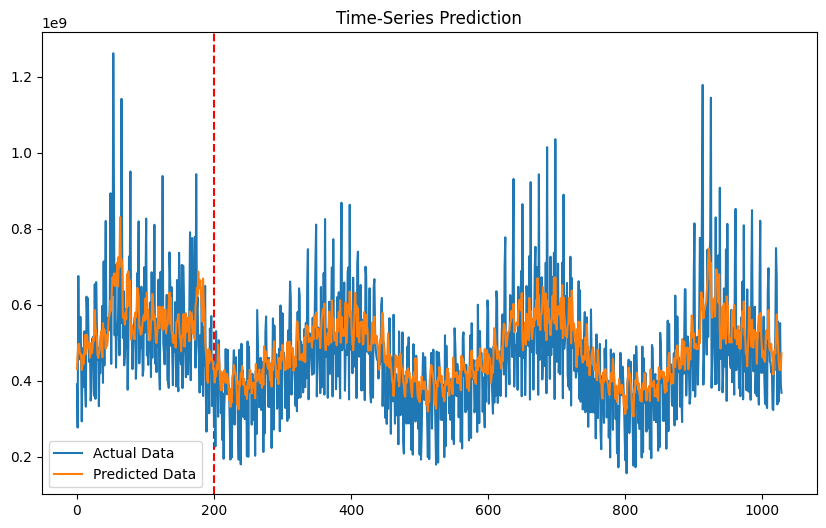

In [49]:

predicted= train_predict * MAX
label_y = y_test * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted[:,0,0], label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [50]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')
# performance

Baseline    : 0.0678
lstm_model  : 0.0430
gru_model   : 0.0468
biLSTM1_model: 0.0438
biLSTM2_model: 0.0436
biLSTM3_model: 0.0437
